In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Define a function for text preprocessing using BERT
def preprocess_text(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids, attention_mask = encoding['input_ids'], encoding['attention_mask']
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state
    embeddings = torch.mean(last_hidden_state, 1)  # Mean pooling
    return embeddings.squeeze().numpy()

In [ ]:

# Load preprocessed and split datasets
train_df = pd.read_csv("train_IFND.csv")
val_df = pd.read_csv("val_IFND.csv")
test_df = pd.read_csv("test_IFND.csv")

In [ ]:

# Apply feature extraction to the datasets
def extract_features_sequential(df):
    text_embeddings = []
    for _, row in df.iterrows():
        text_embeddings.append(preprocess_text(row['Statement']))
    df['Text_Embedding'] = text_embeddings
    df['Combined_Feature'] = df['Text_Embedding']  # Only using text features
    return df

In [ ]:
train_df = extract_features_sequential(train_df)
val_df = extract_features_sequential(val_df)
test_df = extract_features_sequential(test_df)

In [ ]:
# Convert combined features and labels to numpy arrays
def prepare_dataset(df):
    X = np.stack(df['Combined_Feature'].values)
    y = df['Label'].apply(lambda x: 1 if x == 'TRUE' else 0).values
    return X, y

X_train, y_train = prepare_dataset(train_df)
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

In [ ]:
# Create TensorDatasets and DataLoaders
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
# Define the classifier
class TextClassifier(nn.Module):
    def __init__(self, input_dim):
        super(TextClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 2)  # Binary classification
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = TextClassifier(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with early stopping
num_epochs = 10
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_accuracy += (preds == labels).float().mean()

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Evaluate on the test set
model.eval()
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_accuracy += (preds == labels).float().mean()

test_loss /= len(test_loader)
test_accuracy /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/10, Loss: 0.1479, Accuracy: 0.9489
Epoch 2/10, Loss: 0.1391, Accuracy: 0.9527
Epoch 3/10, Loss: 0.1352, Accuracy: 0.9535
Epoch 4/10, Loss: 0.1317, Accuracy: 0.9542
Epoch 5/10, Loss: 0.1301, Accuracy: 0.9566
Epoch 6/10, Loss: 0.1318, Accuracy: 0.9560
Epoch 7/10, Loss: 0.1299, Accuracy: 0.9554
Epoch 8/10, Loss: 0.1256, Accuracy: 0.9568
Epoch 9/10, Loss: 0.1280, Accuracy: 0.9571
Epoch 10/10, Loss: 0.1260, Accuracy: 0.9598
Early stopping triggered
Test Loss: 0.1072, Test Accuracy: 0.9641


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import torch

# Ensure the model is in evaluation mode
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to collect predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculations for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get the index of the max log-probability, i.e., the predicted class
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and true labels to respective lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate classification report
class_report = classification_report(all_labels, all_preds, target_names=['FALSE', 'TRUE'])

# Function to colorize classification report
def colorize_report(report):
    report_lines = report.split('\n')
    new_report = []
    for line in report_lines:
        if line.strip():
            if line.startswith('FALSE') or line.startswith('TRUE'):
                new_report.append('\033[1m' + line + '\033[0m')
            else:
                new_report.append(line)
    return '\n'.join(new_report)

# Colorize classification report
colorized_report = colorize_report(class_report)

# Print colorized classification report
print("Classification Report:")
print(colorized_report)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(all_labels, all_preds)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support
       FALSE       0.97      0.92      0.95      2880
        TRUE       0.96      0.99      0.97      5628
    accuracy                           0.96      8508
   macro avg       0.97      0.95      0.96      8508
weighted avg       0.96      0.96      0.96      8508
ROC-AUC Score: 0.9531


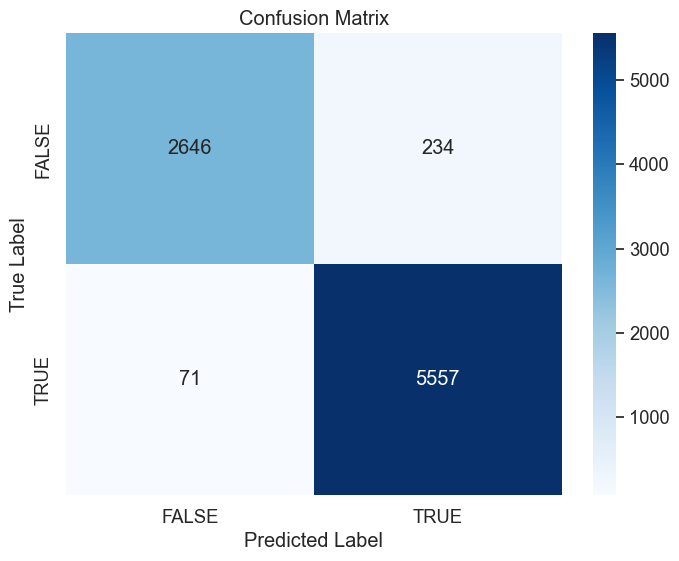

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Define labels
labels = ['FALSE', 'TRUE']

# Create seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [ ]:
model_path = "text_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to text_classifier.pth


In [ ]:
def preprocess_text_batch(text_list):
    embeddings = []
    for text in text_list:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids, attention_mask = encoding['input_ids'], encoding['attention_mask']
        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        embeddings.append(torch.mean(last_hidden_state, 1).squeeze().numpy())
    return embeddings


In [ ]:
# Load the model
model = TextClassifier(input_dim)  # Ensure to define TextClassifier appropriately
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()



# Example new data for inference
new_statements = ["Pune Porsche crash: 15-day punishment for teen shocking, says Devendra Fadnavis.", "AI can be easily used to make fake election photos."]

# Preprocess the new data
new_text_embeddings = preprocess_text_batch(new_statements)  # Ensure to define preprocess_text_batch

# Convert to a single numpy array
new_inputs = np.array(new_text_embeddings)

# Resize or reshape the input tensor to match the expected input dimensions of the model
# For example, if the model expects input of size (batch_size, input_dim), reshape the tensor accordingly
# Replace `input_dim` with the appropriate input dimension expected by your model
new_inputs = new_inputs.reshape(-1, input_dim)  # Adjust the reshape operation based on your model's input shape

# Convert to tensor
new_inputs = torch.tensor(new_inputs, dtype=torch.float32)

# Move the input tensor to the appropriate device (GPU or CPU)
new_inputs = new_inputs.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(new_inputs)
    _, preds = torch.max(outputs, 1)

print(f"Predictions: {preds.cpu().numpy()}")



Predictions: [1 0]


In [ ]:
import pickle

# Save the model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

NameError: name 'model' is not defined

SystemExit: 1